# 05 Error Metrics

_[Estimated execution time: 15 min]_

The toolkit allows to evaluate standard error metrics automatically. This notebook will continue the air quality data set used in the previous tutorial [04 Model Training](https://github.com/GAMES-UChile/mogptk/blob/master/examples/04_Model_Training.ipynb).

In [1]:
import mogptk
import numpy as np
import pandas as pd

# Air Quality MOGP

For this tutorial we will use the air quality dataset. The data set contains hourly averaged responses from an array of five metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located in the field in a significantly polluted area in an Italian city. Data were recorded for one year from March 2004 representing the longest freely available recordings of a deployed air quality chemical sensor device.

We will only use five columns: CO(GT), NMHC(GT), C6H6(GT), NOx(GT), NO2(GT). For more information on data loading check out the tutorial [01 Data Loading](https://github.com/GAMES-UChile/mogptk/blob/master/examples/01_Data_Loading.ipynb). For more information on data handling check out the tutorial [02 Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb).

For each sensor the minimum value is -200, which is also the default value when there is an error in the measurements. We will ignore them by converting them to `NaN`.

In [2]:
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

# Replace missing values with NaN
df.replace(-200.0, np.nan, inplace=True)

# First two columns are date and time
# We convert it to a single column with datetime format
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# Define an initial date to compare all other to it
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# Get elapsed hours
df['Time'] = (df['Date'] - ini_date) / pd.Timedelta(hours=1)

# Use only the first eight days of data
df2 = df[df['Date'] < pd.Timestamp('2004-03-19 00:00:00.0')]

Remove aditional data to simulate sensor failure. In this case for each channel we will first remove 50% of the observations and then remove complete sectors in order to get reconstructions from the other channels through learned cross correlations.

We will also use data transformation as defined in the data preparation and transformation tutorial [02 Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb) where each channel is normalized so it has zero mean and unit variance.

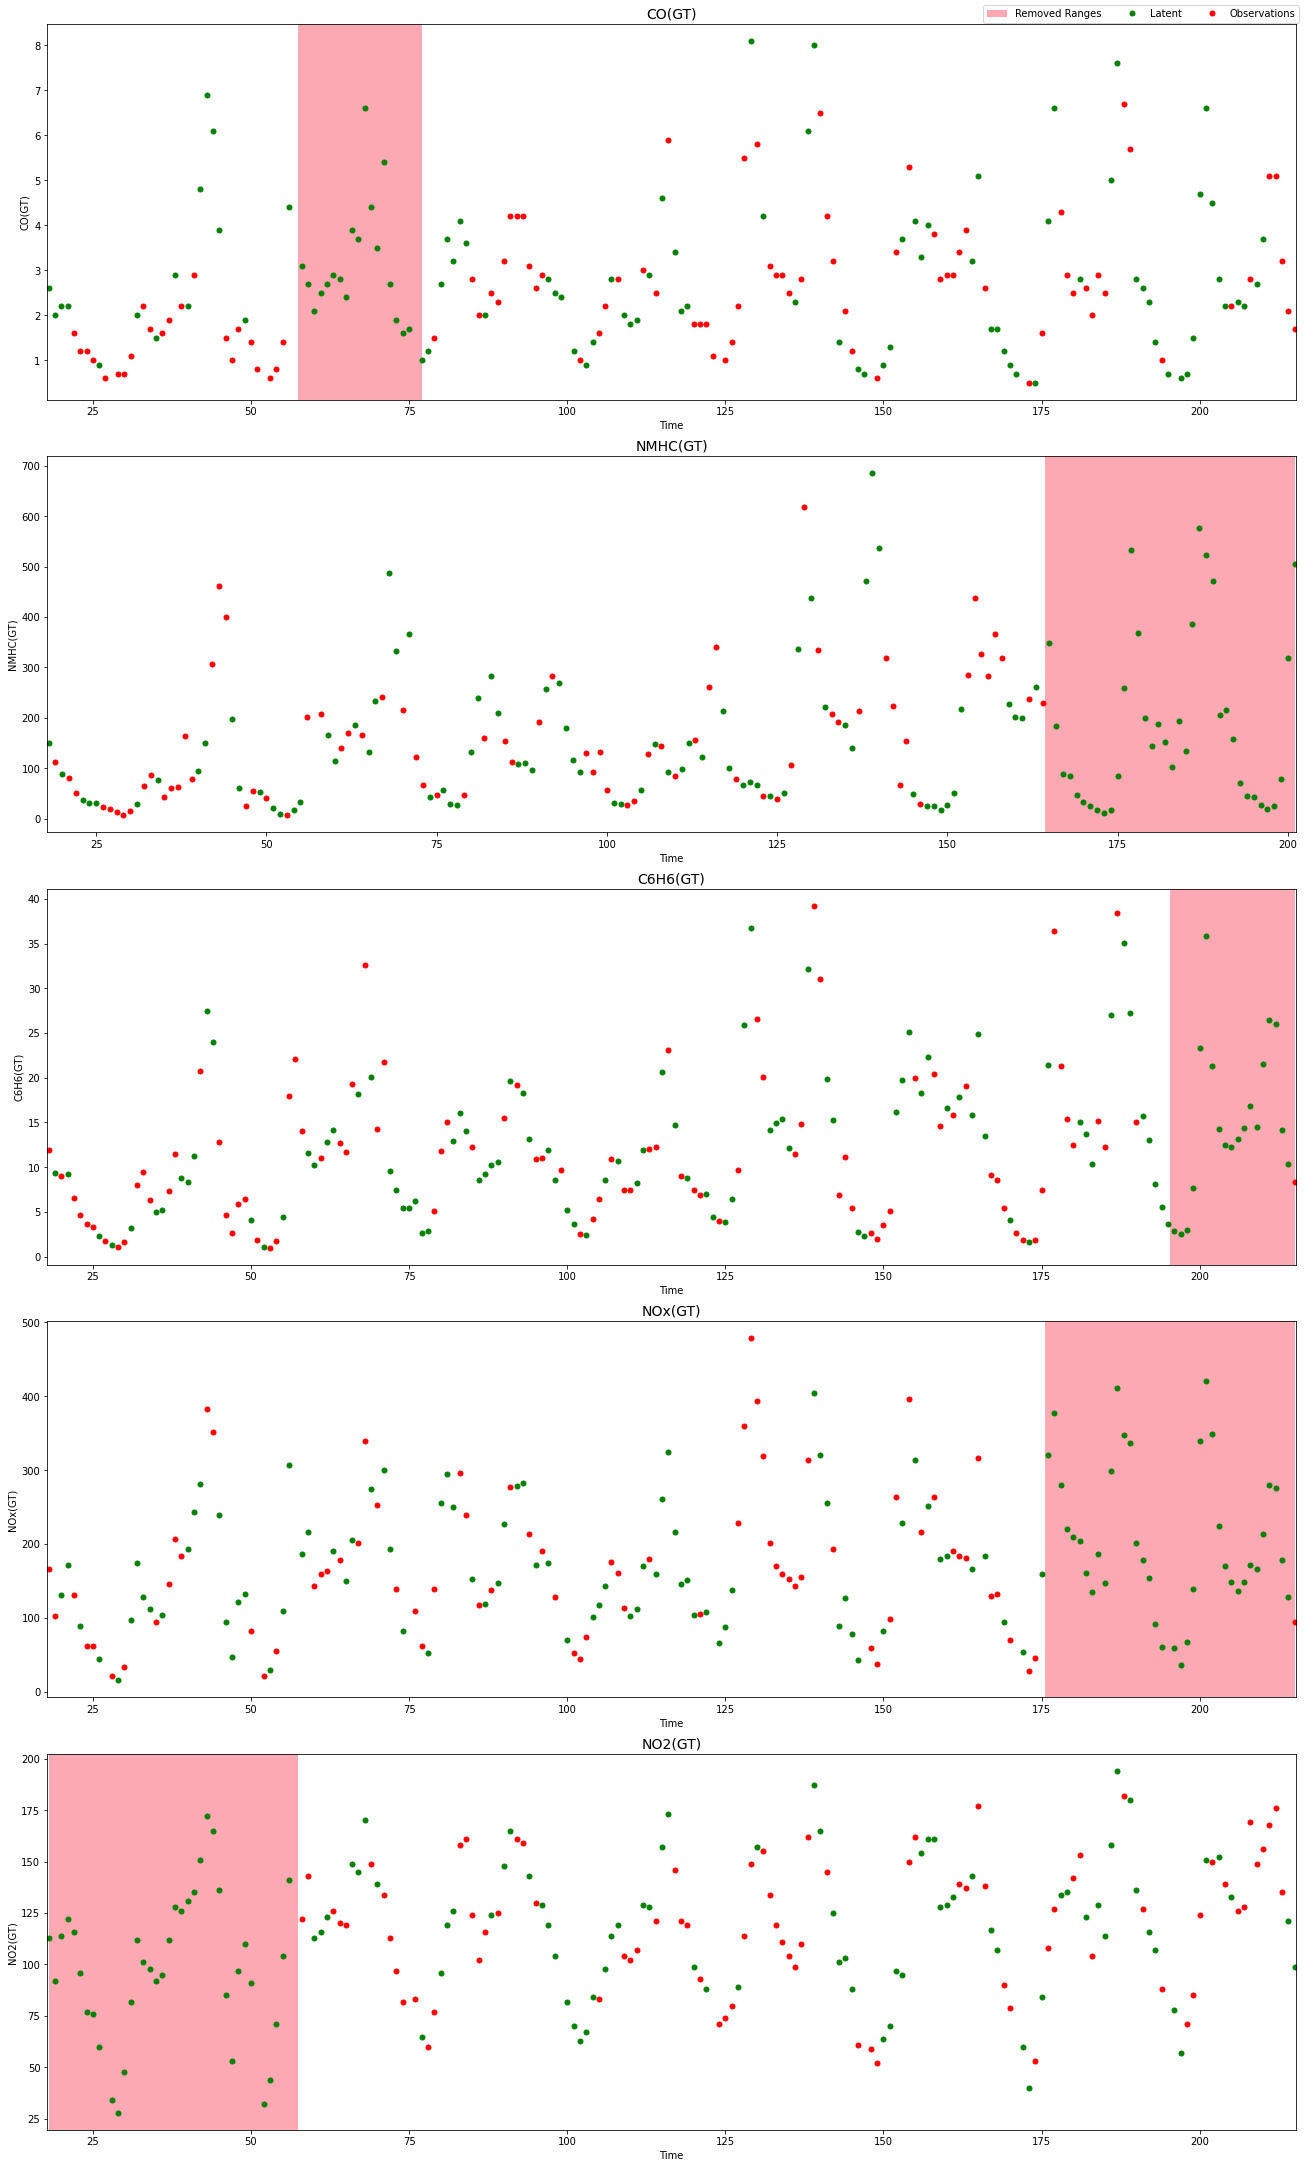

In [3]:
cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
dataset = mogptk.LoadDataFrame(df2, x_col='Time', y_col=cols)

for channel in dataset:
    channel.remove_randomly(pct=0.5)

# drop relative ranges to simulate sensor failure
dataset[0].remove_relative_range(0.2, 0.3)
dataset[1].remove_relative_range(0.8, 1.0)
dataset[2].remove_relative_range(0.9, 1.0)
dataset[3].remove_relative_range(0.8, 1.0)
dataset[4].remove_relative_range(0.0, 0.2)

for channel in dataset:
    channel.transform(mogptk.TransformDetrend(degree=1))
    channel.transform(mogptk.TransformStandard())
dataset.plot();

# Models

We will use one of each of the models in the toolkit, starting with independent Gaussian processes with an [SM](https://games-uchile.github.io/mogptk/sm.html) kernel.

In [4]:
method = 'Adam'
iters = 500
lr = 0.05

## Independent channels with spectral mixture kernels

For each channel we will use four mixtures.


Starting optimization using Adam
‣ Model: SM
‣ Channels: 5
‣ Parameters: 65
‣ Training points: 402
‣ Initial loss: 503.226
‣ Initial error: 33.2931

Start Adam:
    0/500   0:00:00  loss=     503.226  error=     33.2931
    5/500   0:00:00  loss=     497.896  error=     33.9372
   10/500   0:00:00  loss=     489.217  error=     33.0414
   15/500   0:00:00  loss=     482.743  error=     33.5371
   20/500   0:00:00  loss=      476.72  error=     32.7491
   25/500   0:00:01  loss=     471.127  error=     33.3041
   30/500   0:00:01  loss=     465.836  error=     32.6956
   35/500   0:00:01  loss=     460.844  error=     32.8632
   40/500   0:00:01  loss=     456.154  error=     32.8857
   45/500   0:00:01  loss=     451.728  error=      32.892
   50/500   0:00:02  loss=     447.548  error=     32.6396
   55/500   0:00:02  loss=     443.593  error=     32.7133
   60/500   0:00:02  loss=     439.867  error=     32.6249
   65/500   0:00:02  loss=     436.374  error=     32.5903
   70/500   

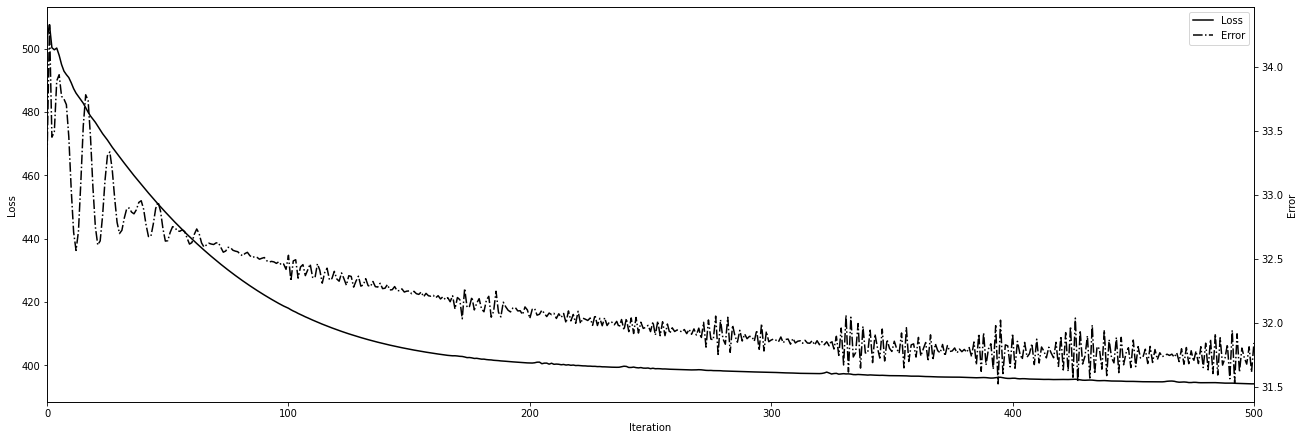

In [5]:
sm = mogptk.SM(dataset, Q=4)
sm.init_parameters('BNSE')
sm.train(method=method, lr=lr, iters=iters,
         verbose=True, error='MAE', plot=True);

### Evaluating errors

Using the [`mogptk.error`](https://games-uchile.github.io/mogptk/errors.html#mogptk.errors.error) function given a test input and output it calculates:

* Mean absolute error (MAE)
* Mean absolute percentage error (MAPE)
* Root mean squared error (RMSE)

If only the raw values $y_{true} - y_{pred}$ are desired, the flag `simple` must be passed.

Multiple models for the same test set (X, Y) can be passed at once, the result will be a list with one element for each model passed, where each element is another list of length equal to the number or channels where each element is the error for said model and channel. This enables to obtain errors for multiple models for the same test set where each channel can have different numbers of test points.

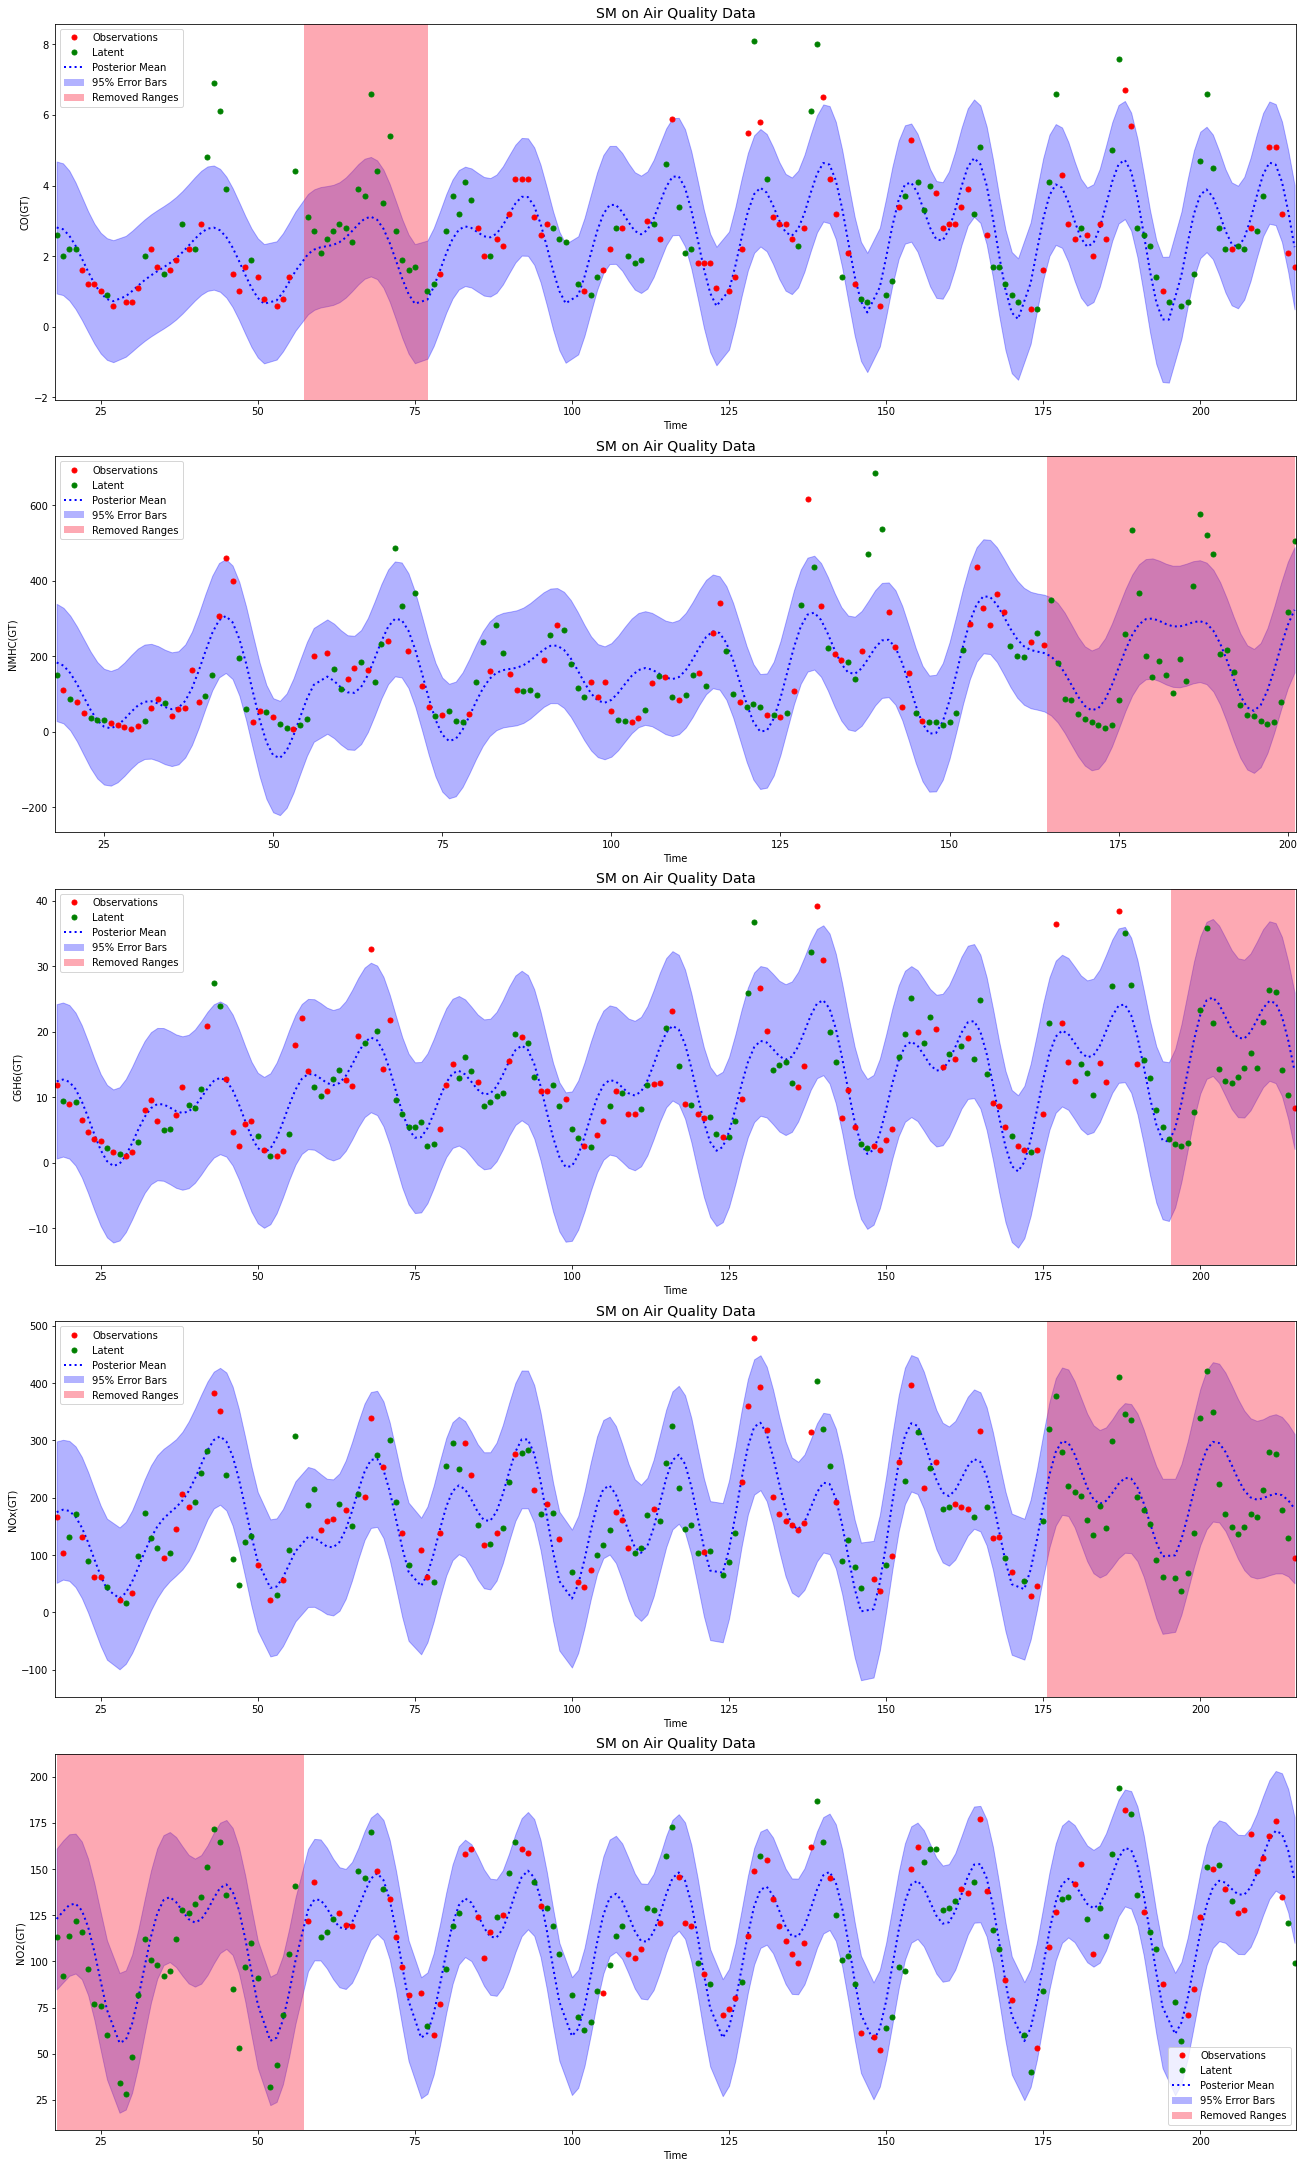

In [6]:
sm.plot_prediction(title='SM on Air Quality Data');

In [7]:
mogptk.error(sm, disp=True, per_channel=False);

,MAE,MAPE,RMSE
Name,,,
SM,31.840617,47.75155,58.443636


## Multi Output Spectral Mixture (MOSM)

Next we use the multi output spectral mixture kernel (Parra et al, 2016).


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 5
‣ Parameters: 105
‣ Training points: 402
‣ Initial loss: 538.303
‣ Initial error: 42.0905

Start Adam:
    0/500   0:00:00  loss=     538.303  error=     42.0905
    5/500   0:00:00  loss=     546.787  error=     44.5344
   10/500   0:00:00  loss=     540.718  error=     43.6076
   15/500   0:00:01  loss=     534.985  error=     43.1139
   20/500   0:00:01  loss=      531.09  error=     42.8474
   25/500   0:00:02  loss=      526.55  error=      42.187
   30/500   0:00:02  loss=     523.114  error=     41.9008
   35/500   0:00:03  loss=     520.795  error=     41.7139
   40/500   0:00:03  loss=     517.502  error=     41.3093
   45/500   0:00:04  loss=     514.388  error=     41.0597
   50/500   0:00:05  loss=     511.372  error=     40.7386
   55/500   0:00:05  loss=     508.364  error=     40.4829
   60/500   0:00:06  loss=      504.94  error=     40.2014
   65/500   0:00:06  loss=     501.645  error=     39.9121
   70/500

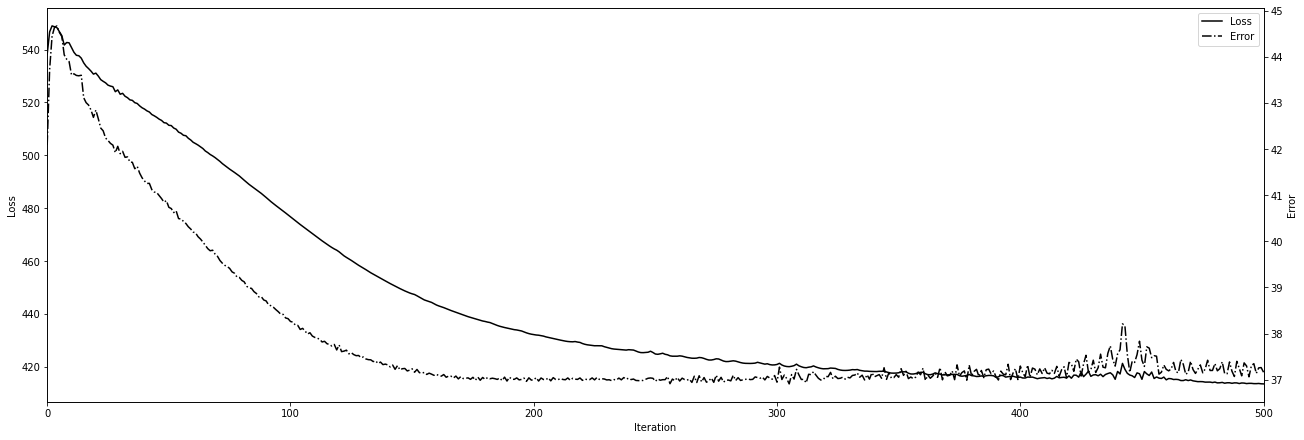

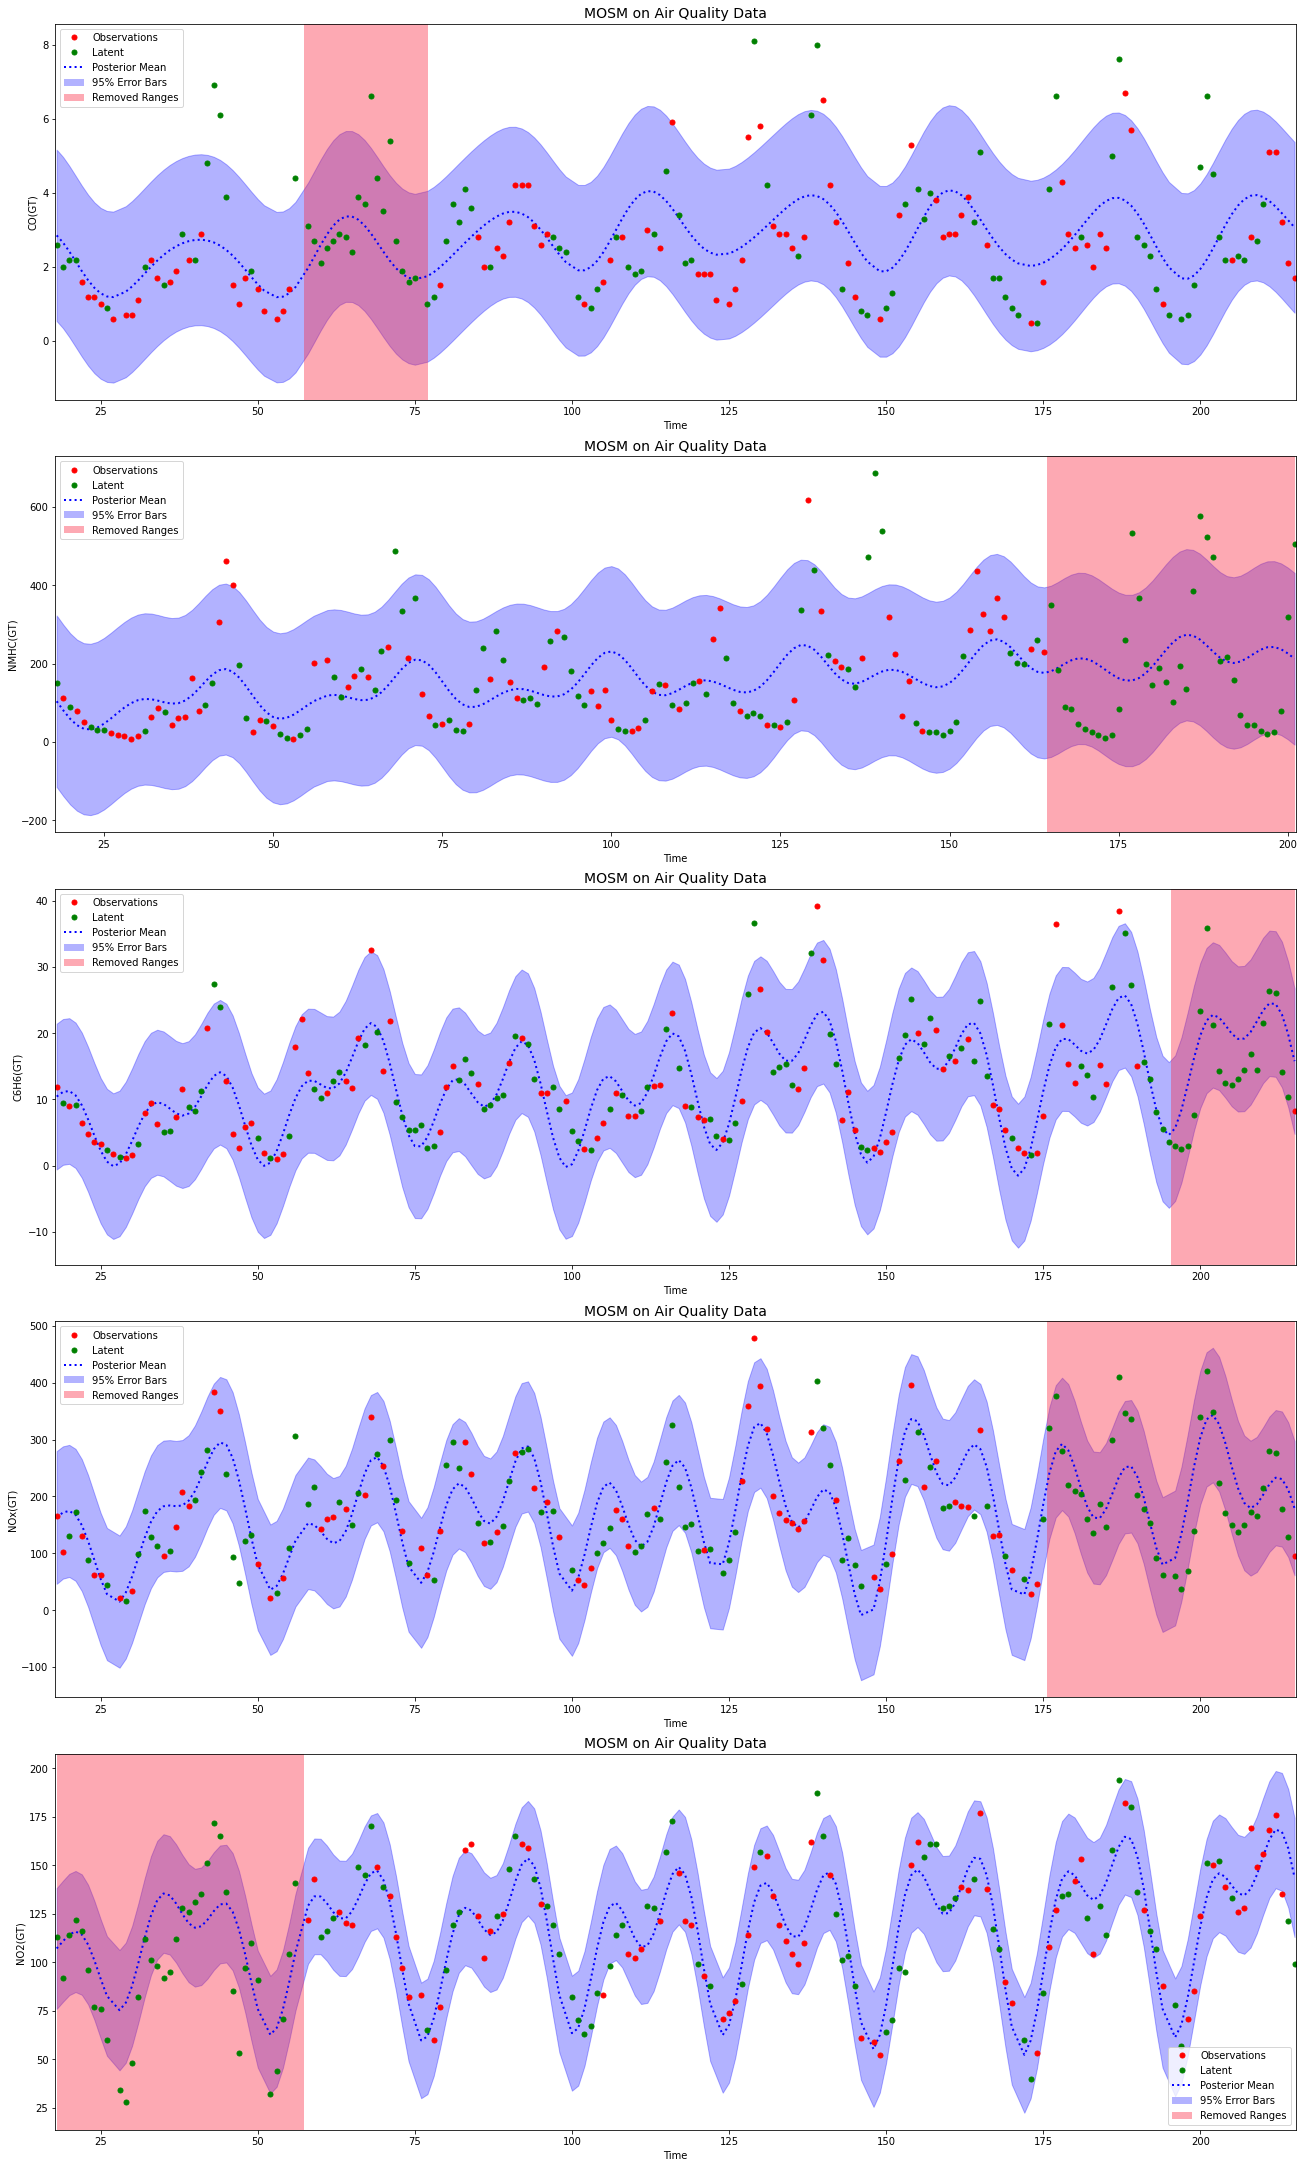

In [8]:
mosm = mogptk.MOSM(dataset, Q=4)
mosm.init_parameters('BNSE')
mosm.train(method=method, lr=lr, iters=iters,
           verbose=True, error='MAE', plot=True)
mosm.plot_prediction(title='MOSM on Air Quality Data');

## Cross Spectral Mixture (CSM)

Then we use the cross spectral mixture kernel (Ulrich et al, 2015).


Starting optimization using Adam
‣ Model: CSM
‣ Channels: 5
‣ Parameters: 53
‣ Training points: 402
‣ Initial loss: 473.578
‣ Initial error: 28.4435

Start Adam:
    0/500   0:00:00  loss=     473.578  error=     28.4435
    5/500   0:00:02  loss=     462.267  error=     28.5251
   10/500   0:00:04  loss=     452.686  error=     29.2235
   15/500   0:00:06  loss=     447.663  error=      29.157
   20/500   0:00:09  loss=      441.75  error=     28.4208
   25/500   0:00:11  loss=     435.853  error=     28.9513
   30/500   0:00:13  loss=     430.834  error=     28.8211
   35/500   0:00:15  loss=     425.952  error=     28.7363
   40/500   0:00:17  loss=     421.358  error=     28.6236
   45/500   0:00:19  loss=     417.136  error=      28.743
   50/500   0:00:21  loss=     413.228  error=     28.7319
   55/500   0:00:23  loss=     409.583  error=      28.707
   60/500   0:00:25  loss=     406.229  error=      28.588
   65/500   0:00:27  loss=     403.133  error=     28.5921
   70/500  

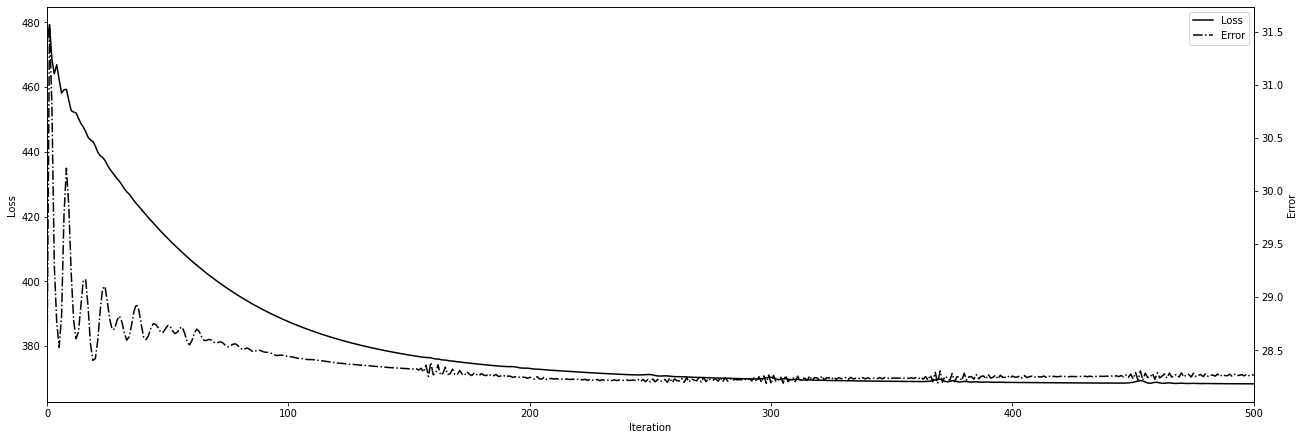

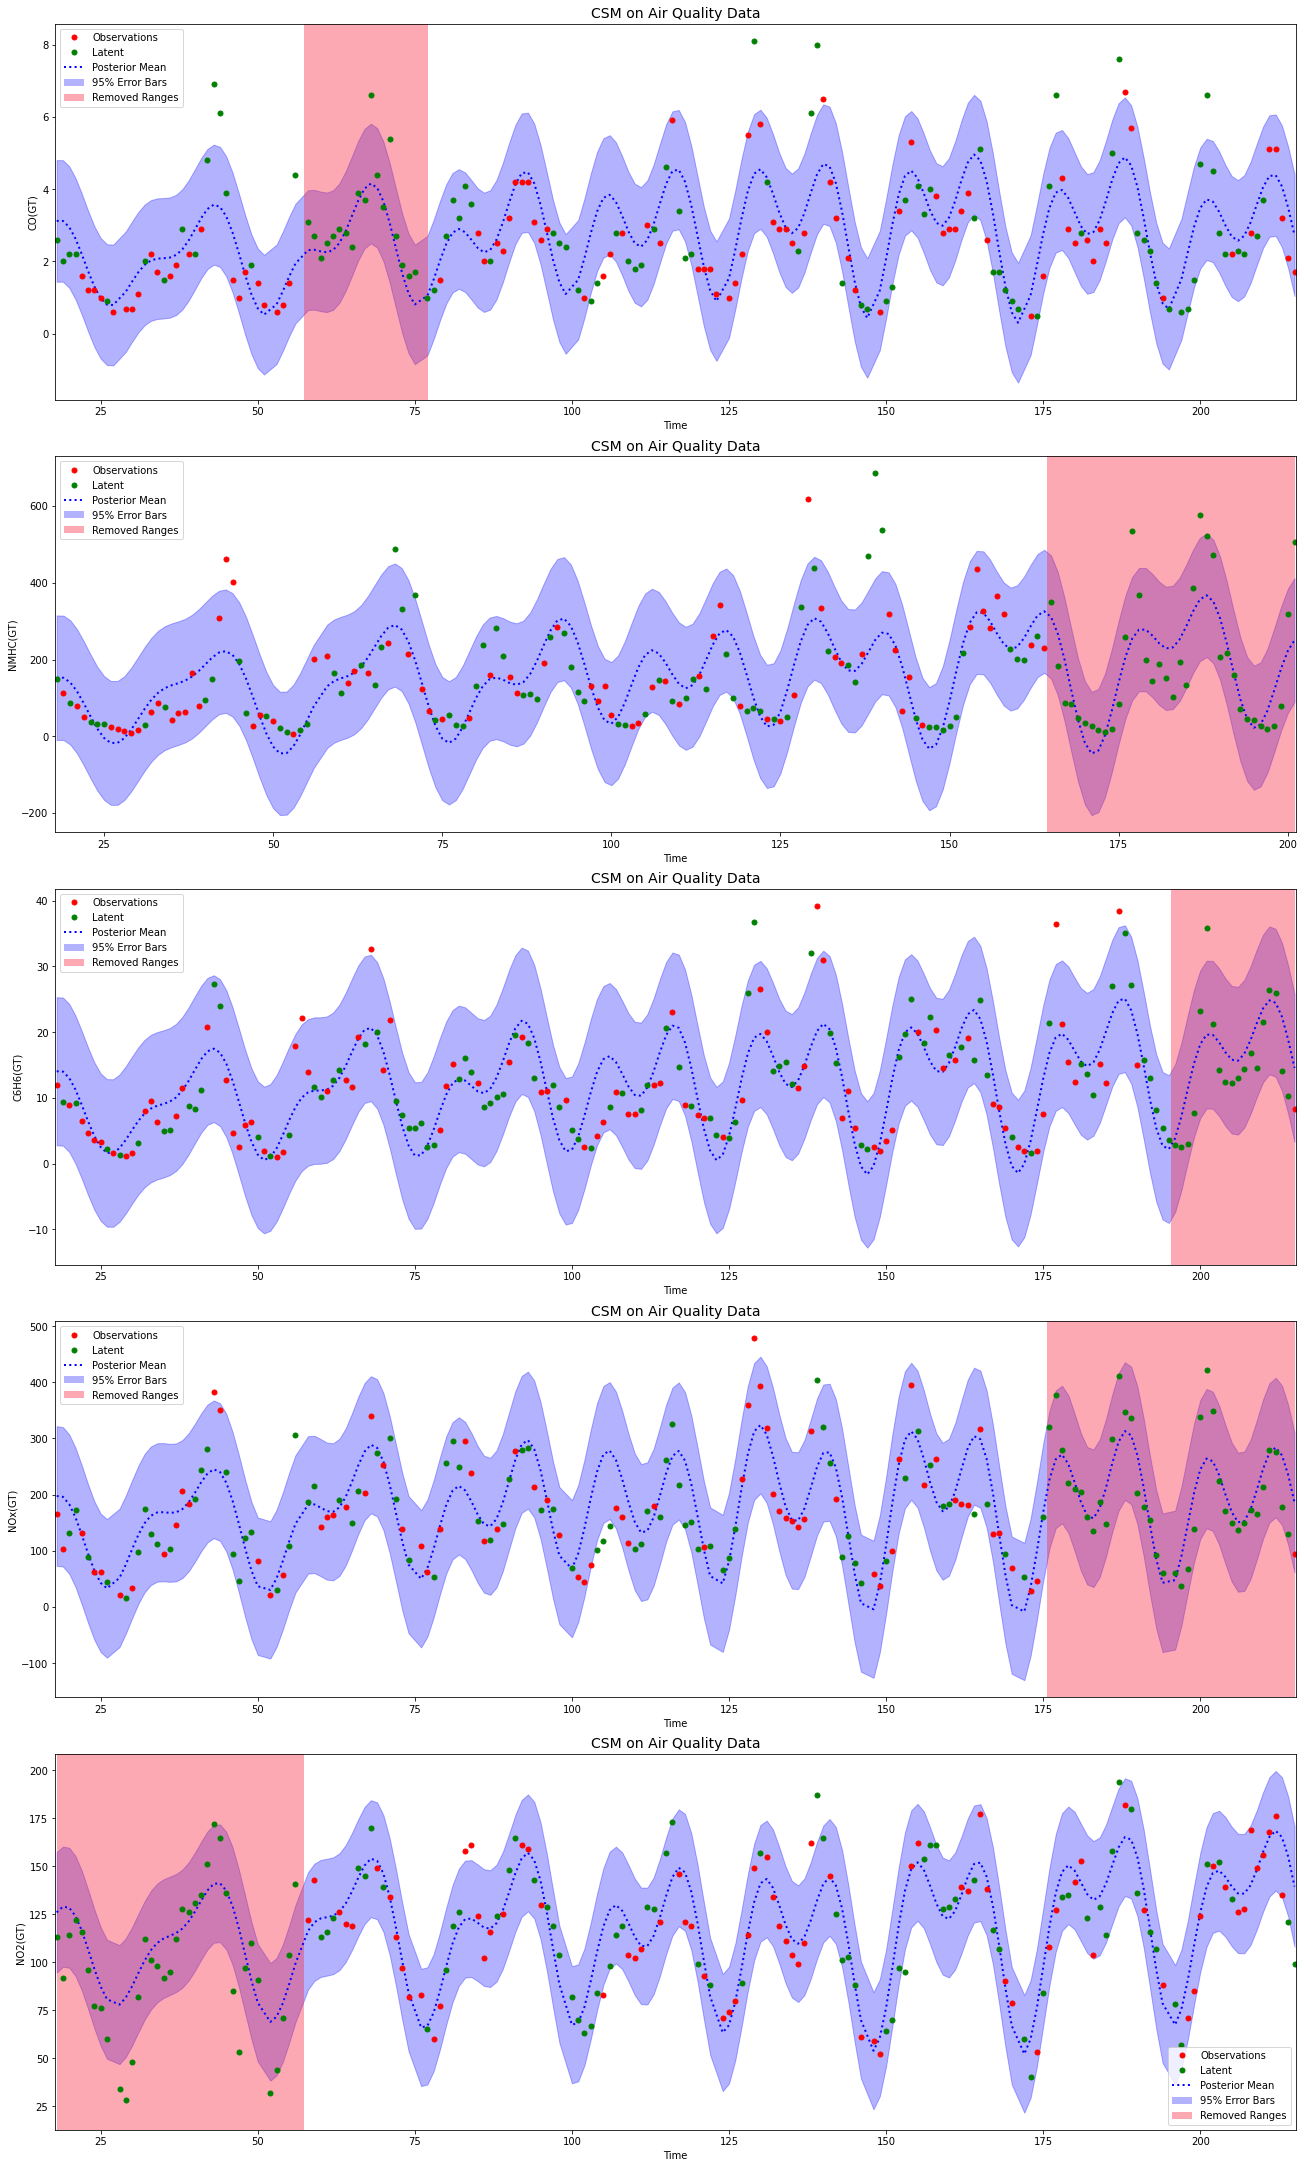

In [9]:
csm = mogptk.CSM(dataset, Q=4)
csm.init_parameters()
csm.train(method=method, lr=lr, iters=iters,
          verbose=True, error='MAE', plot=True)
csm.plot_prediction(title='CSM on Air Quality Data');

## Spectral Mixture - Linear Model of Corregionalization (SM-LMC)

Lastly we fit the spectral mixture linear model of corregionalization (Wilson, 2014).


Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 5
‣ Parameters: 33
‣ Training points: 402
‣ Initial loss: 471.894
‣ Initial error: 27.767

Start Adam:
    0/500   0:00:00  loss=     471.894  error=      27.767
    5/500   0:00:00  loss=     463.752  error=     27.9928
   10/500   0:00:01  loss=     456.346  error=     28.0933
   15/500   0:00:01  loss=     449.342  error=     28.1606
   20/500   0:00:02  loss=     443.058  error=     28.5212
   25/500   0:00:02  loss=     437.238  error=     28.4841
   30/500   0:00:03  loss=     431.349  error=     28.2738
   35/500   0:00:03  loss=     426.032  error=     28.3295
   40/500   0:00:04  loss=     420.709  error=     28.3723
   45/500   0:00:05  loss=     415.791  error=     28.3594
   50/500   0:00:05  loss=      411.02  error=      28.368
   55/500   0:00:06  loss=     406.518  error=     28.3358
   60/500   0:00:06  loss=     402.237  error=     28.3715
   65/500   0:00:07  loss=     398.174  error=     28.3898
   70/500

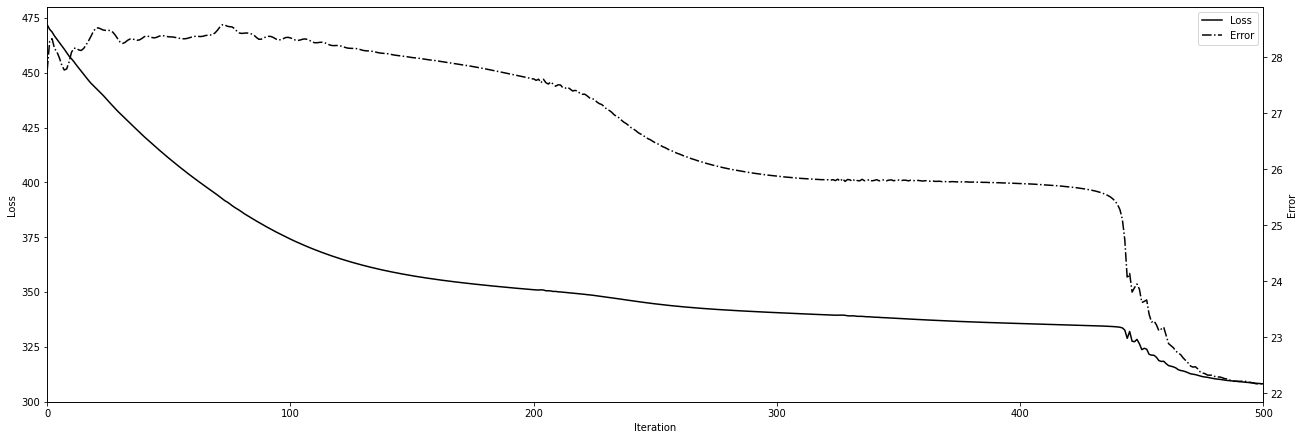

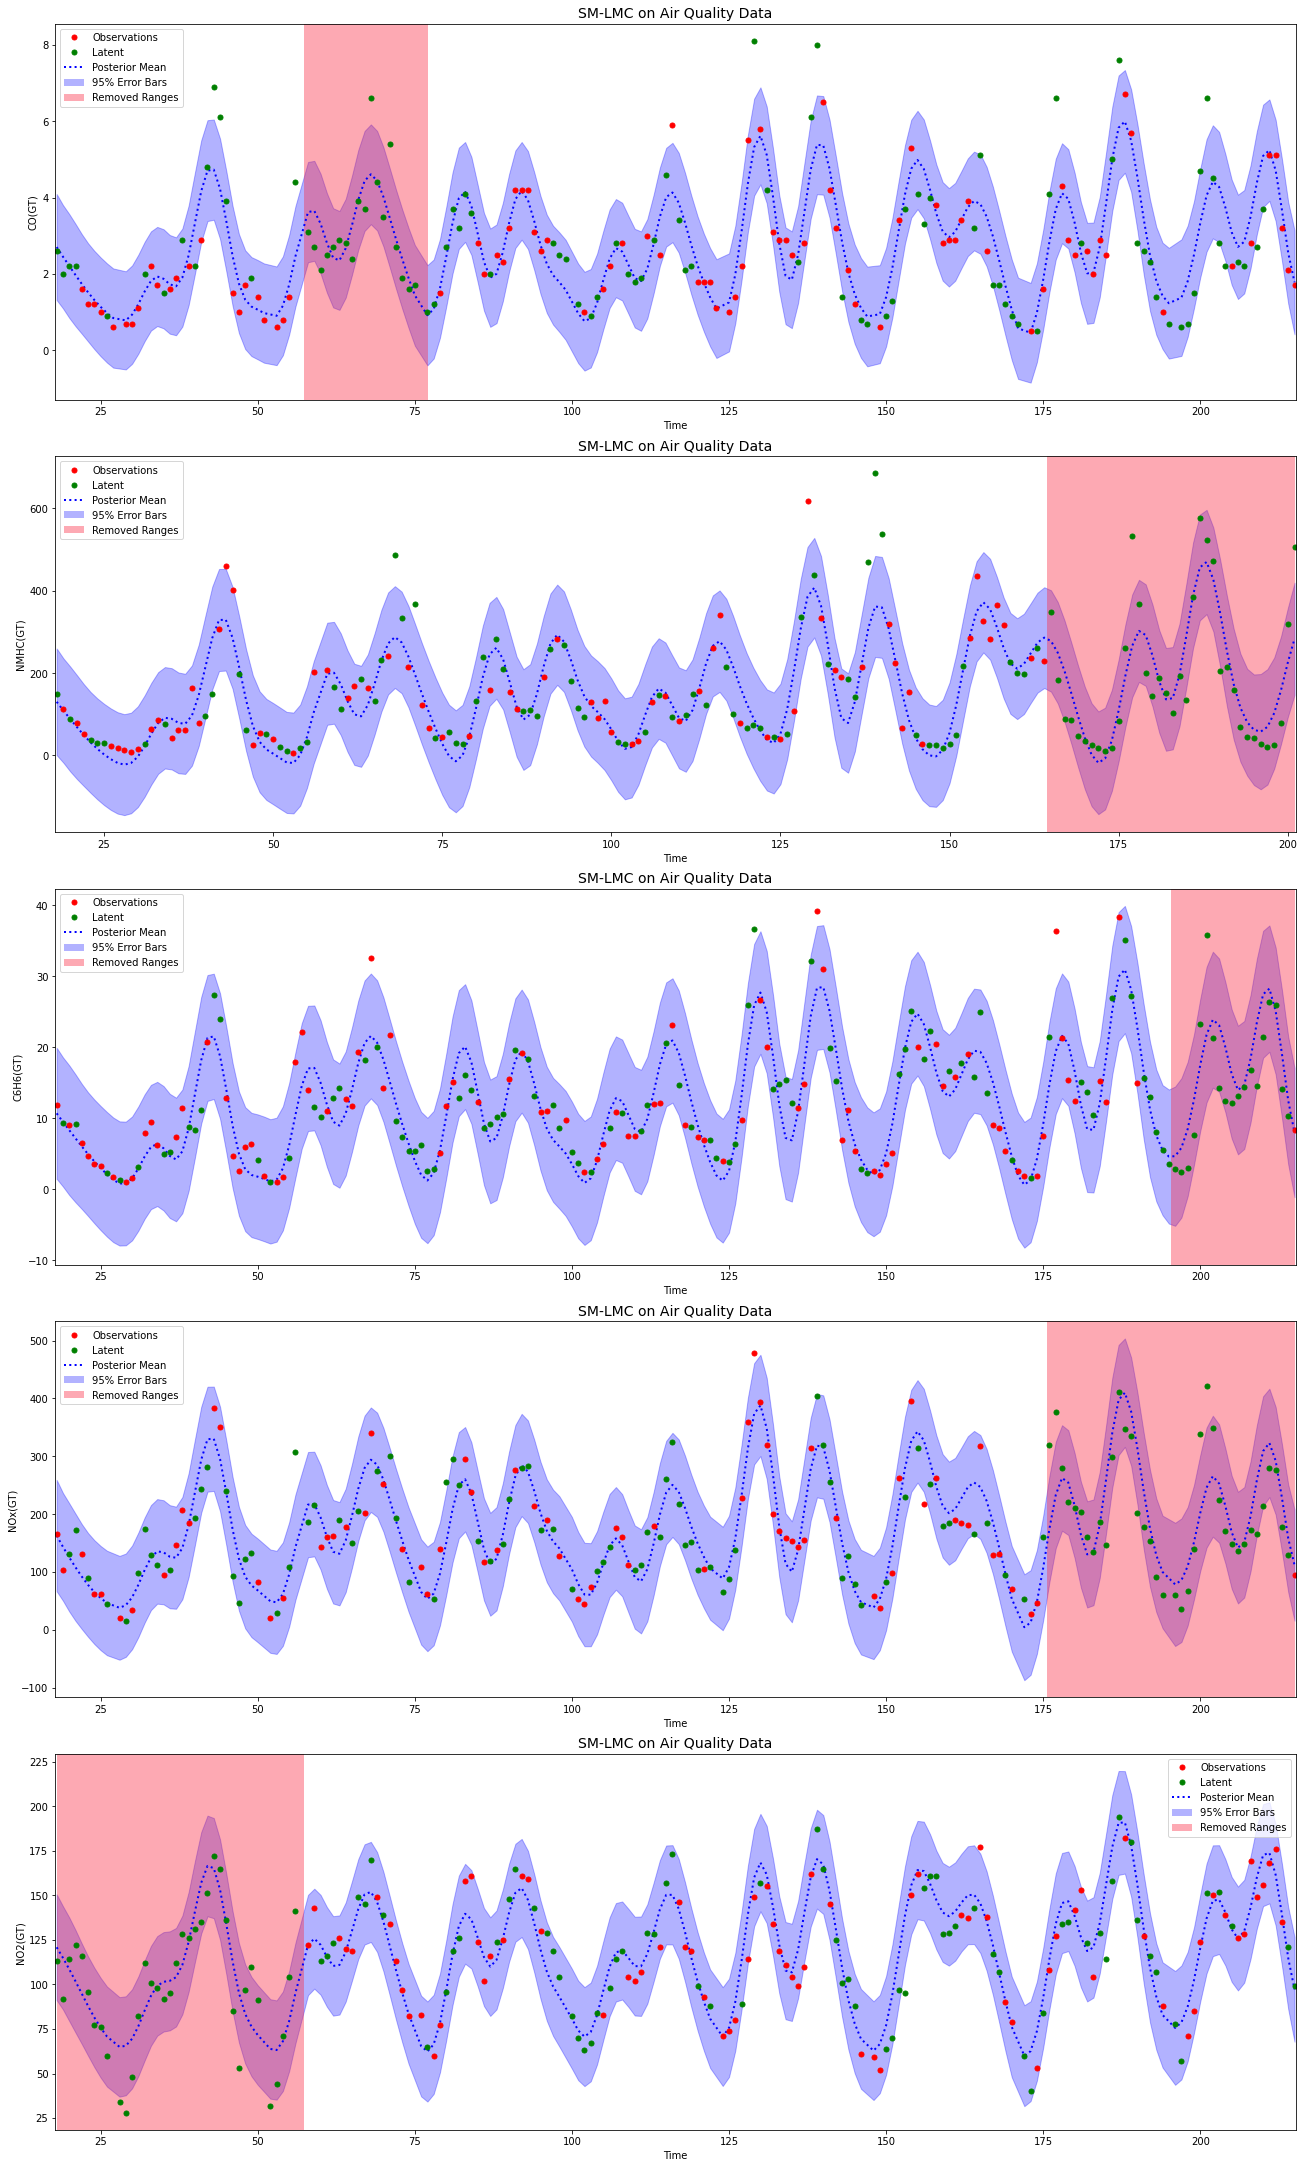

In [10]:
smlmc = mogptk.SM_LMC(dataset, Q=4)
smlmc.init_parameters()
smlmc.train(method=method, lr=lr, iters=iters,
            verbose=True, error='MAE', plot=True)
smlmc.plot_prediction(title='SM-LMC on Air Quality Data');

## Convolutional Gaussian (CONV)


Starting optimization using Adam
‣ Model: CONV
‣ Channels: 5
‣ Parameters: 49
‣ Training points: 402
‣ Initial loss: 514.873
‣ Initial error: 31.721

Start Adam:
    0/500   0:00:00  loss=     514.873  error=      31.721
    5/500   0:00:01  loss=      508.99  error=     30.9761
   10/500   0:00:03  loss=     503.065  error=     30.2364
   15/500   0:00:05  loss=     497.097  error=      29.502
   20/500   0:00:07  loss=     491.082  error=     28.7707
   25/500   0:00:10  loss=     485.019  error=       28.04
   30/500   0:00:12  loss=     478.906  error=     27.3331
   35/500   0:00:14  loss=      472.74  error=     26.6875
   40/500   0:00:16  loss=     466.519  error=     26.0872
   45/500   0:00:17  loss=     460.243  error=     25.5193
   50/500   0:00:19  loss=     453.912  error=     24.9642
   55/500   0:00:20  loss=     447.532  error=     24.4283
   60/500   0:00:23  loss=     441.108  error=      23.922
   65/500   0:00:25  loss=     434.647  error=     23.4217
   70/500  

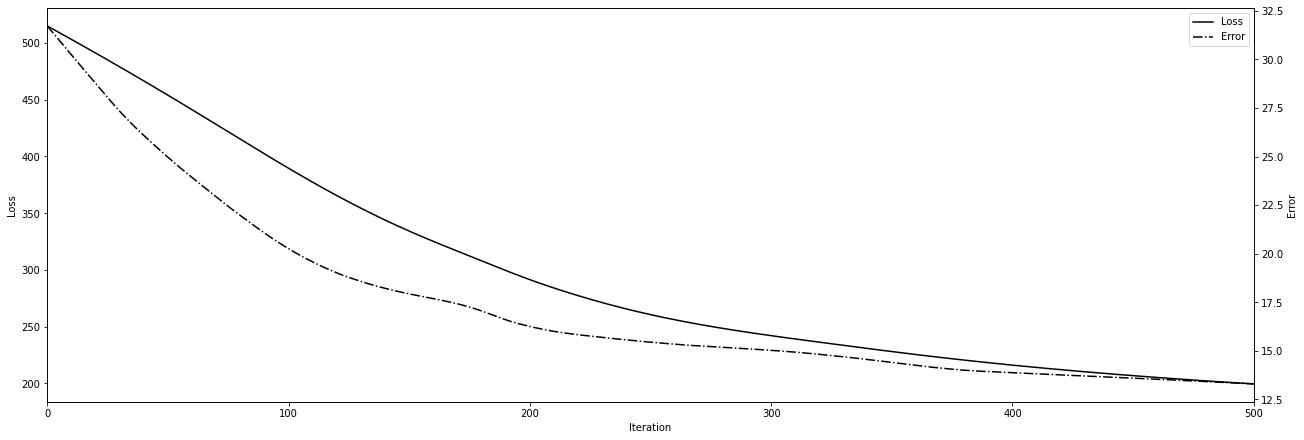

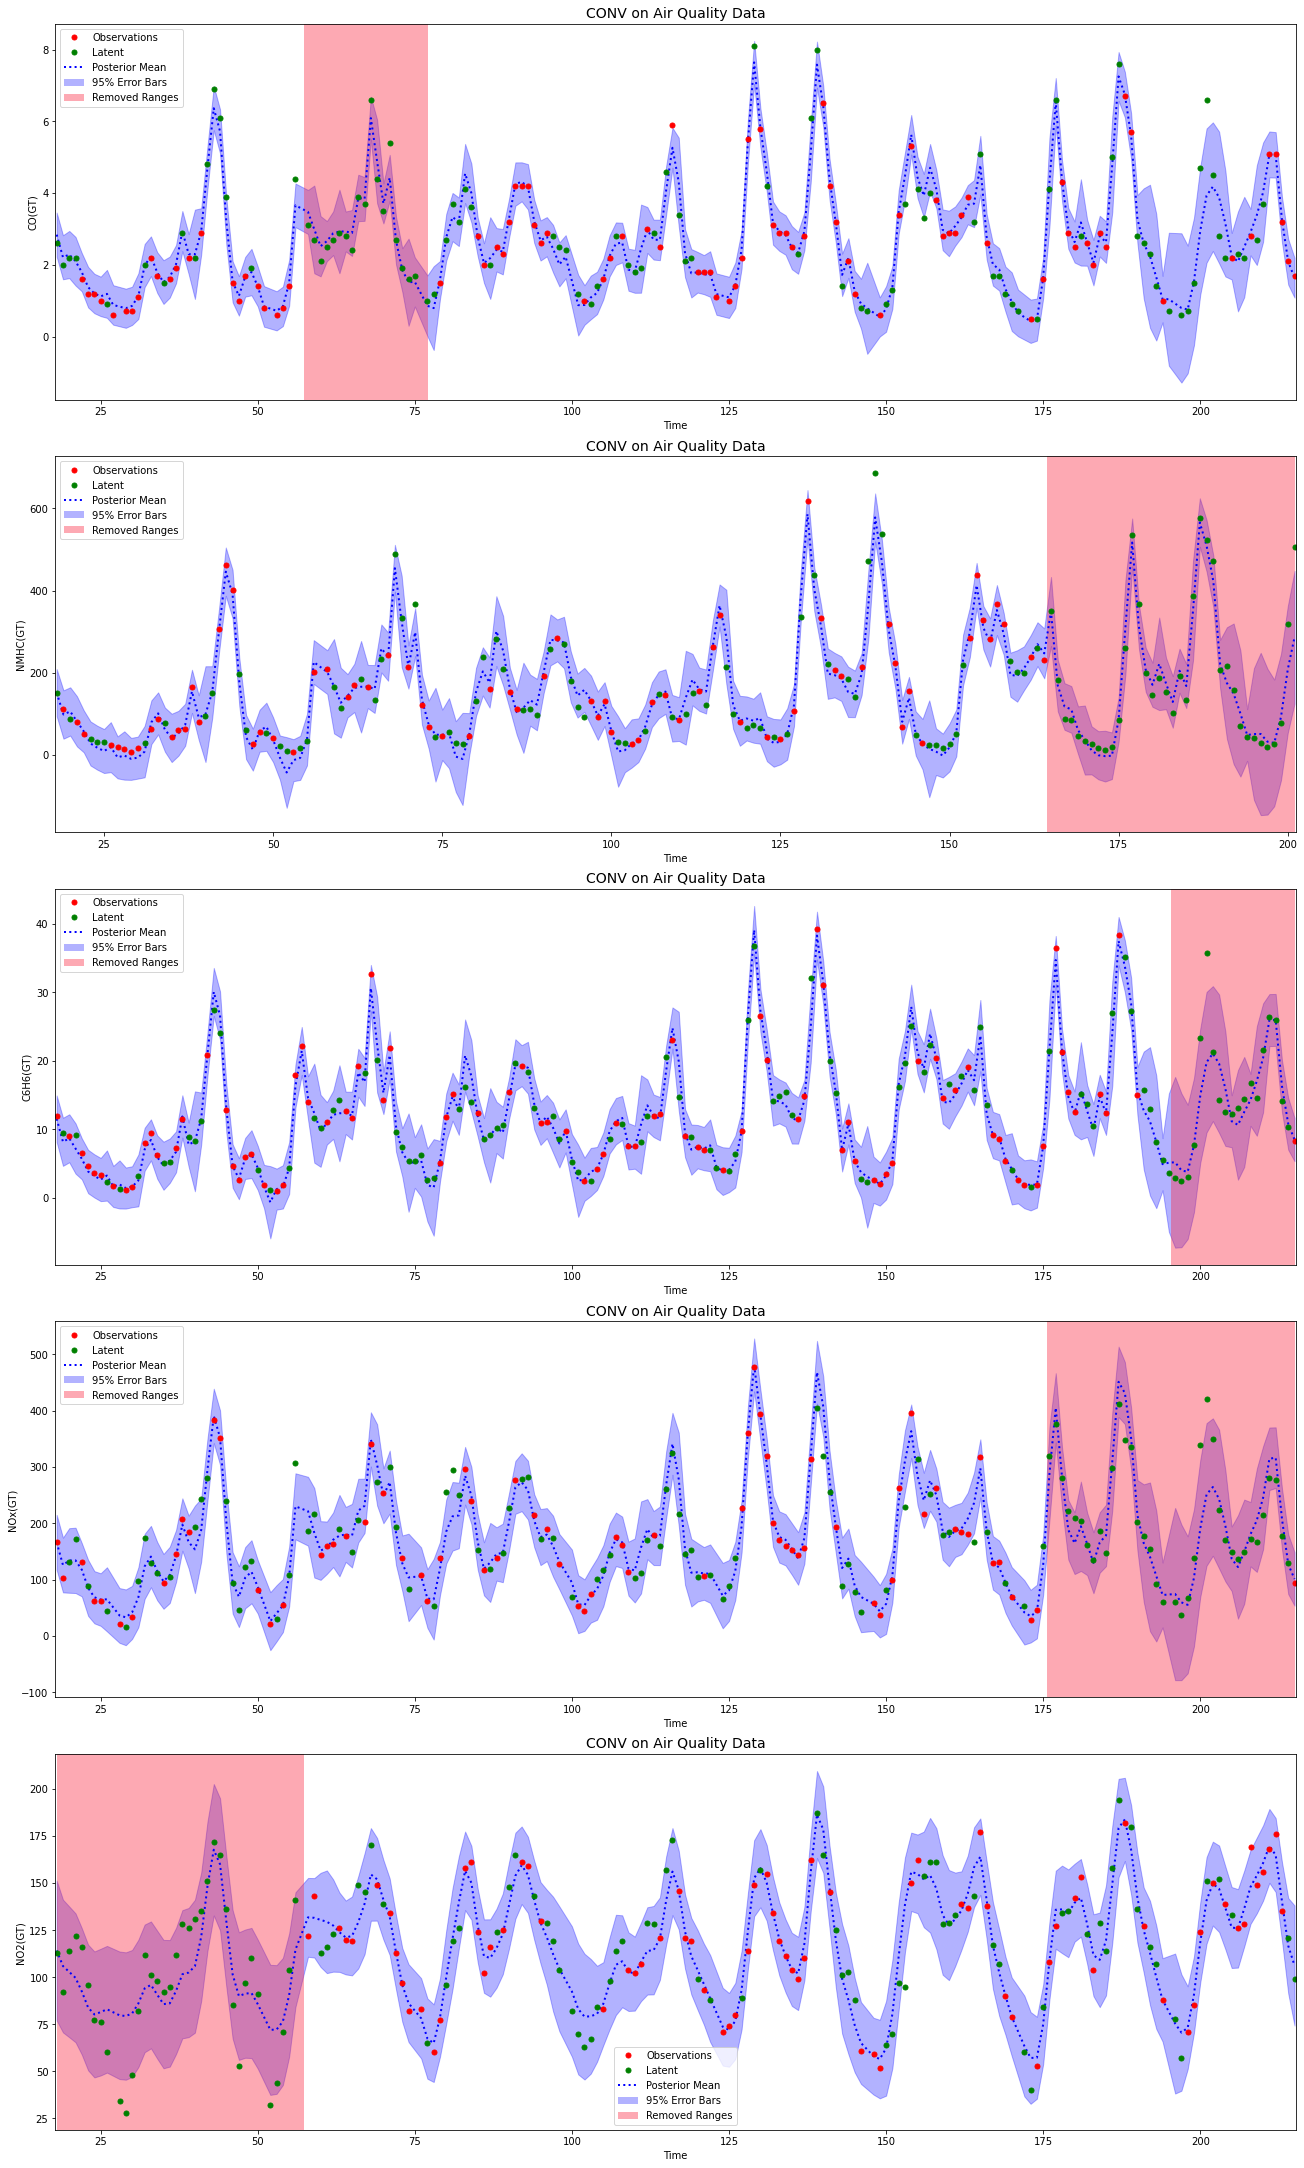

In [11]:
conv = mogptk.CONV(dataset, Q=4)
conv.init_parameters()
conv.train(method=method, lr=lr, iters=iters,
           verbose=True, error='MAE', plot=True)
conv.plot_prediction(title='CONV on Air Quality Data');

# Compare errors

We will take the mean MAE, MAPE, and RMSE for all the channels and compare all the models.

In [12]:
mogptk.error(sm, mosm, csm, smlmc, conv, disp=True)

,MAE,MAPE,RMSE
Name,,,
SM,31.840617,47.751550,58.443636
MOSM,37.160805,65.353113,71.388803
CSM,28.263449,42.516146,53.322366
SM-LMC,22.167511,30.401371,43.084923
CONV,13.294705,18.211582,25.173724
